# Continuous Control

---

Solution is heavily based on course material and previous exercises.



### 1. Start the environment and load packacges


In [2]:
!pip -q install ./python # only needed for udacity workspace

In [13]:
#import some useful packages
from collections import deque
import time
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch

In [3]:
from unityagents import UnityEnvironment

# change to Reacher single env path
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Define useful environment variables


In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Define DDPQ agent


In [7]:
from ddpg_agent import Agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed = 0)

In [10]:
def ddpg(agent, num_episodes=1000, max_t=3000, train=True, stepsize = 100, printevery=25):
    '''
    Deep Deterministic Policy Gradient (DDQN) Algorithm.
    
    Params
    ======
        num_episodes (int): number of training episodes (maximum)
        max_t (int): maximum number of timesteps per episode
        train (bool): True = training mode, False = inference/test/play mode
        stepsize (int): length of window that is used for score averaging
        printevery (int): frequency of printing information throughout episode iteration 
    
    '''
    stepsize = stepsize
    scores = []                                          # initialize the score
    scores_window = deque(maxlen=stepsize)  # last X scores
    scores_window_small = deque(maxlen=printevery)  # last X scores

    start = time.time()        # set timer

    for i in range(1,num_episodes+1):
        score = 0                                          # initialize score
        env_info = env.reset(train_mode=train)[brain_name]  # reset env
        agent.reset()                                      # reset agent
        state = env_info.vector_observations[0]              # get initial state
        for t in range(max_t):
            action = agent.act(state) # select an action 
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            if train:                
                agent.step(state, action, reward, next_state, done) # update agent (only when training)
            score += reward                               # update the score
            state = next_state                            # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        scores.append(score)                               # append score
        scores_window.append(score)                        # append score to sliding window
        scores_window_small.append(score)                        # append score to sliding window

        print('\rEpisode {}\tScore: {:.2f}'.format(i, score), end="")

        if i % printevery == 0:
            stop = time.time() - start
            print('\rEpisode {}\tScore 100: {:.2f} \tScore 25: {:.2f} \tTime elapsed: {}'.format(i, np.mean(scores_window), np.mean(scores_window_small), int(stop)))
        
        if i % 50 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_{:d}.pth'.format(i))
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_{:d}.pth'.format(i))
            np.savetxt('scores_{:d}.txt'.format(i), scores)
            
        if np.mean(scores_window)>=30.0 and train:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i-stepsize, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_success.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_success.pth')
            break
                
    return scores

### 4. Train agent and show scores

In [11]:
#training (about 3.5 hours with GPU support)
scores = ddpg(agent)

Episode 25	Score 100: 0.65 	Score 25: 0.65 	Time elapsed: 307
Episode 50	Score 100: 1.46 	Score 25: 2.28 	Time elapsed: 620
Episode 75	Score 100: 1.86 	Score 25: 2.65 	Time elapsed: 934
Episode 100	Score 100: 2.36 	Score 25: 3.87 	Time elapsed: 1257
Episode 125	Score 100: 3.26 	Score 25: 4.25 	Time elapsed: 1578
Episode 150	Score 100: 4.13 	Score 25: 5.74 	Time elapsed: 1899
Episode 175	Score 100: 5.49 	Score 25: 8.09 	Time elapsed: 2222
Episode 200	Score 100: 6.52 	Score 25: 7.99 	Time elapsed: 2541
Episode 225	Score 100: 7.84 	Score 25: 9.55 	Time elapsed: 2867
Episode 250	Score 100: 8.78 	Score 25: 9.49 	Time elapsed: 3191
Episode 275	Score 100: 9.69 	Score 25: 11.73 	Time elapsed: 3516
Episode 300	Score 100: 11.48 	Score 25: 15.14 	Time elapsed: 3840
Episode 325	Score 100: 12.83 	Score 25: 14.98 	Time elapsed: 4164
Episode 350	Score 100: 13.85 	Score 25: 13.56 	Time elapsed: 4488
Episode 375	Score 100: 14.54 	Score 25: 14.48 	Time elapsed: 4809
Episode 400	Score 100: 14.12 	Score 2

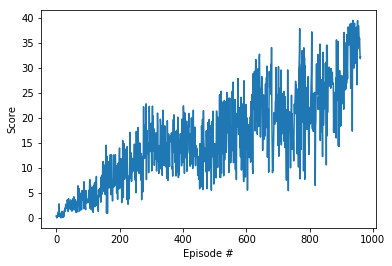

In [14]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [15]:
env.close()